Example of nonlinear denoising with Wavelets : a use case of pypwt
----------------------------------------------------------------------

`pypwt` is a parallel implementation of the Discrete Wavelet Transform (DWT). It features DWT and SWT (stationary wavelet transform) in both separable and non-separable modes, for 2D data.


In [1]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


Import the module "pypwt". All the useful things are in the class "Wavelets"

In [2]:
from pypwt import Wavelets

ImportError: No module named 'pypwt'

Create a noisy image. Here the test image is "Lena". The image is corrupted with a Gaussian noise ; the STD is 5% of the image maximum value.

In [19]:
from scipy.misc import lena
l = lena()
ln = l + np.random.randn(*l.shape)*l.max()*0.05

In [20]:
def ims(img, cmap=None, legend=None):
    # Determine if img is actually a list of images
    try:
        _ = img.shape
        nimg = 1
    except AttributeError:
        nimg = len(img)
    #
    if (nimg <= 2): shp = (1,2)
    elif (nimg <= 4): shp = (2,2)
    elif (nimg <= 6): shp = (2,3)
    elif (nimg <= 9): shp = (3,3)
    else: raise ValueError("too many images")
    #
    plt.figure()
    for i in range(nimg):
        curr = list(shp)
        curr.append(i+1)
        curr = tuple(curr)
        if nimg > 1:
            plt.subplot(*curr)
            im = img[i]
            if legend: leg = legend[i]
        else: 
            im = img
            if legend: leg = legend
        if cmap:
            plt.imshow(im, cmap=cmap, interpolation="nearest")
        else:
            plt.imshow(im, interpolation="nearest")
        if legend: plt.xlabel(leg)
        plt.colorbar()
    
    plt.show()

<IPython.core.display.Javascript object>


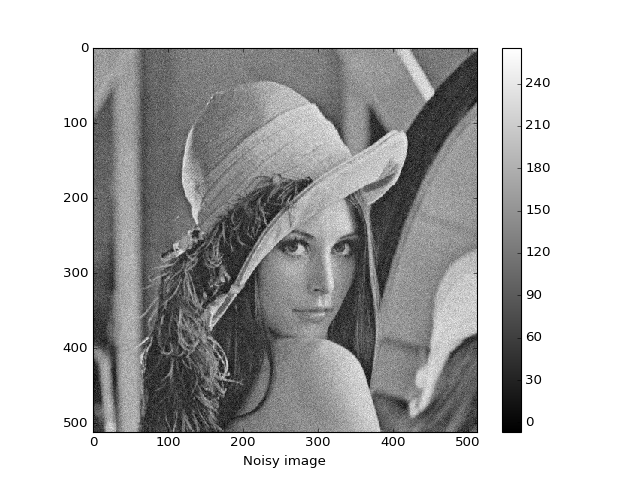

In [21]:
ims(ln, cmap="gray", legend="Noisy image")

Create a Wavelets plan. Here we take the "Daubechies 2" wavelets, and 3 decomposition levels. 

For a better denoising capability, the stationary wavelet transform (SWT, or undecimated DWT) is computed.

In [29]:
W = Wavelets(ln, "db2", 3, do_swt=1)

The class is created, but the forward transform has still to be performed.

In [30]:
W.forward()

The wavelets coefficients can be retrieved from the GPU by simply calling `W.coeffs` :

<IPython.core.display.Javascript object>


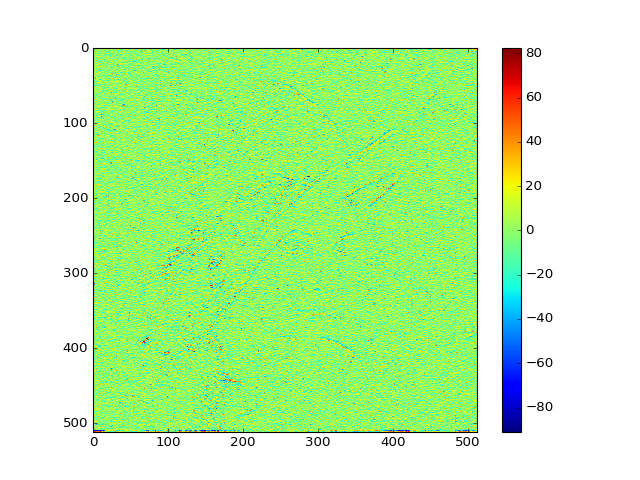

In [31]:
c = W.coeffs
ims(c[1][0]) # detail coefficients at level 1

Apply some thresholding on the wavelets coefficients. The soft thresholding is the best denoising operation in the L2-L1 sense 
(i.e the solution of $\underset{x}{\text{argmin}} \frac{1}{2}\left\|x - y\right\|_2^2 + \lambda \left\| x \right\|_1 $).

The noise is not correlated to the image, and is hopefully captured by the detail coeffs. We choose therefore to not threshold the approximation coefficients.

In [32]:
W.soft_threshold(20.0, do_threshold_appcoeffs=0)

<IPython.core.display.Javascript object>


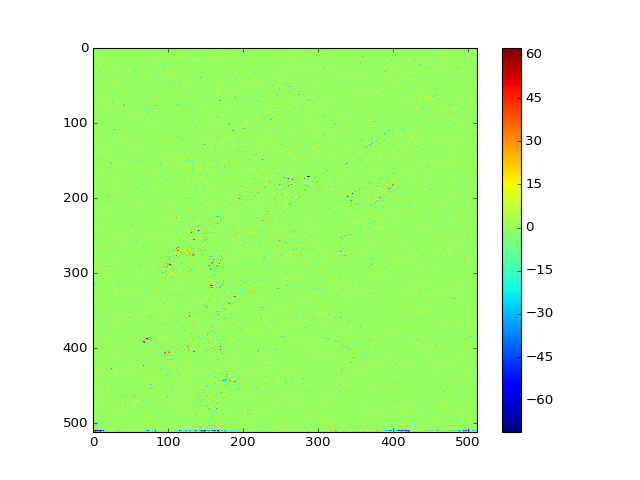

In [33]:
c = W.coeffs # W.coeffs was modified on the GPU by soft_threshold(). We have to retrieve the coefficients again
ims(c[1][0])

Now compute the inverse Wavelet Transform. The resulting image can be retrieved from the GPU by simply calling `W.image`.

Note that in the current implementation, the `W.inverse()` operation is in-place and therefore modifies the coefficients.
This means that no further processing should be done on `W.coeffs` after `W.inverse()`.

In [34]:
W.inverse()

<IPython.core.display.Javascript object>


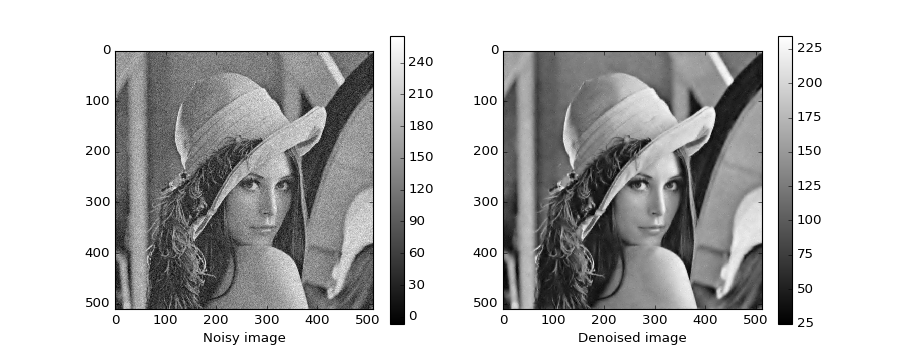

In [35]:
ims([ln, W.image], cmap="gray", legend=["Noisy image", "Denoised image"])